In [1]:
import os
# print(os.getcwd())

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action="ignore")

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import utils

# Config
sns.set_context('notebook', font_scale=1.3)

## Functions

In [2]:
def plot_trajectory_hued(
    df,
    pat_id,
    time_col="months_since_first_session",
    group_column="is_proctored",
    ax=None,
):
    ### VARS
    figsize = (10, 5)
    colors = sns.color_palette("colorblind").as_hex()
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Primer scatter
    colors = {'fvc': colors[0], 'svc': colors[3]}
    vars   = {'fvc': 'fvcPercPred_2019', 'svc': 'vcPercPred'}
    for pft in {'fvc','svc'}:
        data_proc = df.query('subject_id == @pat_id and pftType == @pft and is_proctored == True')
        x1_plot = data_proc[time_col].values
        y1_plot = data_proc[vars[pft]].values
        ax.scatter(
                x1_plot,
                y1_plot,
                color=colors[pft],
                marker='o',
                label='Proctored',
                s=55,
            )
        
        # Segundo scatter
        data_nonproc = df.query('subject_id == @pat_id and pftType == @pft and is_proctored == False')
        x2_plot = data_nonproc[time_col].values
        y2_plot = data_nonproc[vars[pft]].values
        ax.scatter(
                x2_plot,
                y2_plot,
                color=colors[pft],
                marker='o',
                linewidth=2,
                facecolors="none",
                label='Non Proctored',
                s=55,
            )
    
    # Regressions
    for pft in {'fvc','svc'}:
        data_proc = df.query('subject_id == @pat_id and pftType == @pft')
        x1_fit = data_proc[time_col].values
        y1_fit = data_proc[vars[pft]].values
        
        #########################
        (y_pred, _, _, _, slope, _, intercept, _) = utils.fit_regression(x1_fit, y1_fit, output_all=True)
        #########################
        x1_fit = np.append(x1_fit, 0)
        y_pred = np.append(y_pred, intercept)

        # # Extend forward
        # x1_fit = np.append(x1_fit, 15)
        # y_pred = np.append(y_pred, 15 * slope + intercept)
        ax.plot(
                x1_fit,
                y_pred,
                color='black',
                linewidth=2,
                label=None,
            )
        
    plt.grid()

def plot_trajectory_panels_fig2(
    df: pd.DataFrame,
    pat_list: list,
    figsize=(35 * 0.5, 20 * 0.5),
    **kwargs,
):
    
    n_cols = 6
    n_rows = 2
    
    # Creating the shared subplots (occupying the left half)
    fig = plt.figure(figsize=figsize, layout='constrained')
    gs = GridSpec(ncols=n_cols, nrows=n_rows, figure=fig, width_ratios=[1.5,1.5,1,1,1,1])
    
    # Create the subplots dynamically
    axs = [
            fig.add_subplot(gs[0, 0]), 
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 0]), 
            fig.add_subplot(gs[1, 1])
    ]    
    
    for i, pat in enumerate(pat_list):
        
        plot_trajectory_hued(df, pat, ax=axs[i])
        axs[i].set_xticks(range(0,20,4))
        axs[i].set_yticks([0, 50, 100, 150])
        axs[i].set_xlim(0, 16)
        axs[i].set_ylim(0, 150)
        axs[i].grid(True)
        
        # add patient id
        pat_ord = df[df['subject_id'] == pat]['subject_order'].values[0]
        print(pat,' - ', pat_ord)
        axs[i].text(0.05, 0.05, pat_ord, fontsize=14, transform=axs[i].transAxes, ha='left', va='bottom')
    
    fig.text(.22, -.025, kwargs.get('xlabel', 'Months since enrollment'), ha='center', va='center', fontsize=20)
    fig.text(-.025, 0.5, 'FVC/SVC % predicted', ha='center', va='center', rotation='vertical', fontsize=20)
    
    #######################
    # Slopes
    single_ax = fig.add_subplot(gs[:, 2:4])
    col1 = 'slope_fvcPercPred_2019'
    col2 = 'slope_vcPercPred'
    aux = df.groupby('subject_id')[[col1, col2]].first() * 30
    corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    
    single_ax.scatter(aux[col1],
                      aux[col2],
                      edgecolor='k', 
                      alpha=0.7,
                      color='grey',
                    )
    
    # single_ax.legend([f'Corr: {corr} (p-val: ({p_val}))\nN subjects: {len(aux)}'], loc='best', handlelength=0, handletextpad=0)
    print(f'Corr slopes: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}')
    # for handle in single_ax.legend_.legendHandles:
    #     handle.set_visible(False)
    single_ax.set_xlabel('Slope FVC % predicted / mo', fontsize=20)
    single_ax.set_ylabel('Slope SVC % predicted / mo', fontsize=20)
    min_val = -5
    max_val = 5
    single_ax.set_xticks([-4, -2, 0, 2, 4])
    single_ax.set_yticks([-4, -2, 0, 2, 4])
    single_ax.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=2)
    single_ax.grid(True)
    
    #######################
    # Intercepts
    single_ax_2 = fig.add_subplot(gs[:, 4:6])
    col1 = 'intercept_fvcPercPred_2019'
    col2 = 'intercept_vcPercPred'
    aux = df.groupby('subject_id')[[col1, col2]].first()
    
    corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    
    single_ax_2.scatter(aux[col1],
                        aux[col2], 
                        edgecolor='k', 
                        alpha=0.7, 
                        color='grey', 
                        )
    
    # single_ax_2.legend([f'Corr: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}'], loc='best', handlelength=0, handletextpad=0)
    print(f'Corr intercepts: {corr} (p-val: ({p_val}))\nN subjects: {(len(aux))}')
    # for handle in single_ax_2.legend_.legendHandles:
    #     handle.set_visible(False)
    single_ax_2.set_xlabel('Intercept FVC % predicted', fontsize=20)
    single_ax_2.set_ylabel('Intercept SVC % predicted', fontsize=20)
    min_val = 39
    max_val = 145
    single_ax_2.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=2)
    single_ax_2.grid(True)
    
    #######################
    # Format 
    # letters with automatic positioning
    axs[0].text(0.00, 1.35, 'a', fontsize=30, transform=axs[0].transAxes, va='top', ha='left')
    single_ax.text(0.00, 1.15, 'b', fontsize=30, transform=single_ax.transAxes, va='top', ha='left')
    single_ax_2.text(0.00, 1.15, 'c', fontsize=30, transform=single_ax_2.transAxes, va='top', ha='left')

    plt.show()

## Data

In [3]:
PATH = 'data'
FILE = 'data_fig2.csv'
df_data = pd.read_csv(os.path.join(PATH,FILE))

print(f'N subjects: {df_data.subject_id.nunique()}')
print(f"N sessions: {df_data.session_id.nunique()}")

df_data.shape

N subjects: 37
N sessions: 955


(1598, 16)

### Figuras

In [4]:
patient_sorted = [
    'b323b082-0ca4-4b58-b899-3e87e41074fb',
    '095b55de-6600-4d17-b8e6-387a7ef9db6f',
    'fc3f4670-6329-4886-868e-81eb8f8f7ba3',
    '9941063b-9b74-4eb0-b24f-b73cb9324ee5',
]

b323b082-0ca4-4b58-b899-3e87e41074fb  -  pALS 5
095b55de-6600-4d17-b8e6-387a7ef9db6f  -  pALS 31
fc3f4670-6329-4886-868e-81eb8f8f7ba3  -  pALS 6
9941063b-9b74-4eb0-b24f-b73cb9324ee5  -  pALS 43
Corr slopes: 0.736 (p-val: (0.0))
N subjects: 37
Corr intercepts: 0.97 (p-val: (0.0))
N subjects: 37


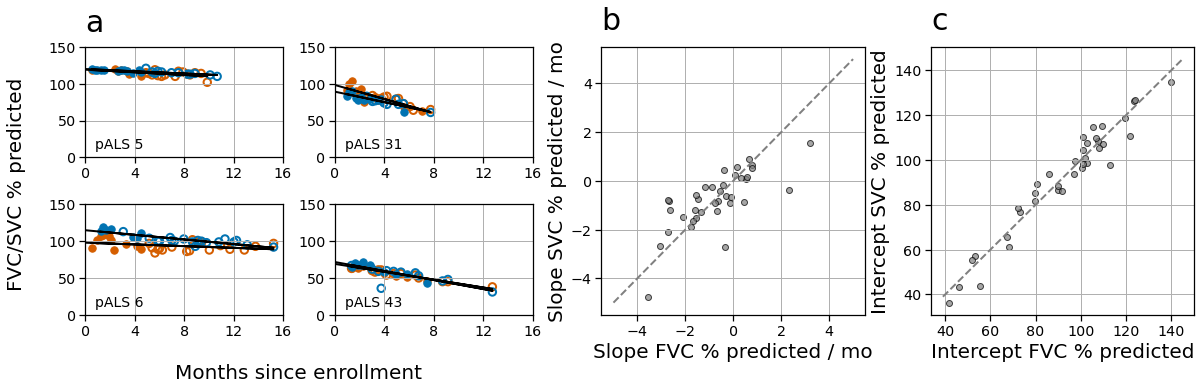

In [5]:
# Figura 
TIME_COL = 'months_since_first_session'

plot_trajectory_panels_fig2(
                        df_data, 
                        patient_sorted,
                        figsize=(16, 5))